# WordNet Selector

In [62]:
from pathlib import Path
from itertools import chain
from more_itertools import collapse
import pandas as pd
from nltk.corpus import wordnet as wn
import re
from IPython.display import Image, display

In [2]:
dataset_v1 = Path('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000')
dataset_v2 = Path('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000r2')

In [71]:
def get_dataset(image_name):
    if re.match(r'^n[0-9]+', image_name):
        return 'ImageNet'
    elif re.match(r'^COCO', image_name):
        return 'COCO'
    else:
        return 'Scene'

def get_synset(image_name):
    offset = re.search(r'(?<=^n)[0-9]+', image_name).group(0)
    synset = wn.synset_from_pos_and_offset('n', int(offset))
    return synset.name()

def get_hypernym_paths(synset):
    paths = wn.synset(synset).hypernym_paths()
    # Convert to list of strings
    paths = [[hypernym.name() for hypernym in path] for path in paths]
    return paths

def get_ranks(paths):
    # Deep copy of paths
    paths = [path.copy() for path in paths]
    path_sets = []
    while True:
        rank = set([path.pop(0) for path in paths if path])
        
        if rank:
            path_sets.append(rank)
        else:
            break

    return path_sets

def show_images(search):
    stimuli = dataset_v2 / 'BOLD5000_Stimuli' / 'Scene_Stimuli' / 'Presented_Stimuli'
    
    image_paths = stimuli.glob(f'**/*{search}*')
    
    for image in image_paths:
        display(Image(filename=image))
        
def show_synset(search):
    synsets = wn.synsets(search, wn.NOUN)
    
    for synset in synsets:
        print(synset)
        print(synset.offset())
        show_images(synset.offset())

In [4]:
df = pd.read_pickle(dataset_v2 / 'CSI1_dataframe.pkl')
df = df[df.dataset == 'ImageNet'].copy()
df

,image,dataset
0,n01930112_19568.JPEG,ImageNet
1,n03733281_29214.JPEG,ImageNet
2,n07695742_5848.JPEG,ImageNet
5,n01917289_1429.JPEG,ImageNet
6,n02108551_26574.JPEG,ImageNet
...,...,...
5243,n09421951_5433.JPEG,ImageNet
5245,n02018207_3567.JPEG,ImageNet
5247,n01692333_12353.JPEG,ImageNet
5248,n03240683_13368.JPEG,ImageNet


In [5]:
# Process synsets
df['synset'] = df.image.map(get_synset)
df['hypernym_paths'] = df.synset.map(get_hypernym_paths)
df['num_paths'] = df.hypernym_paths.map(lambda p: len(p))
df['ranks'] = df.hypernym_paths.map(get_ranks)
df

,image,dataset,synset,hypernym_paths,num_paths,ranks
0,n01930112_19568.JPEG,ImageNet,nematode.n.01,"[[entity.n.01, physical_entity.n.01, object.n....",1,"[{entity.n.01}, {physical_entity.n.01}, {objec..."
1,n03733281_29214.JPEG,ImageNet,maze.n.01,"[[entity.n.01, physical_entity.n.01, object.n....",1,"[{entity.n.01}, {physical_entity.n.01}, {objec..."
2,n07695742_5848.JPEG,ImageNet,pretzel.n.01,"[[entity.n.01, physical_entity.n.01, matter.n....",2,"[{entity.n.01}, {physical_entity.n.01}, {matte..."
5,n01917289_1429.JPEG,ImageNet,brain_coral.n.01,"[[entity.n.01, physical_entity.n.01, object.n....",1,"[{entity.n.01}, {physical_entity.n.01}, {objec..."
6,n02108551_26574.JPEG,ImageNet,tibetan_mastiff.n.01,"[[entity.n.01, physical_entity.n.01, object.n....",2,"[{entity.n.01}, {physical_entity.n.01}, {objec..."
...,...,...,...,...,...,...
5243,n09421951_5433.JPEG,ImageNet,sandbar.n.01,"[[entity.n.01, physical_entity.n.01, object.n....",2,"[{entity.n.01}, {physical_entity.n.01}, {objec..."
5245,n02018207_3567.JPEG,ImageNet,american_coot.n.01,"[[entity.n.01, physical_entity.n.01, object.n....",1,"[{entity.n.01}, {physical_entity.n.01}, {objec..."
5247,n01692333_12353.JPEG,ImageNet,gila_monster.n.01,"[[entity.n.01, physical_entity.n.01, object.n....",1,"[{entity.n.01}, {physical_entity.n.01}, {objec..."
5248,n03240683_13368.JPEG,ImageNet,drilling_platform.n.01,"[[entity.n.01, physical_entity.n.01, object.n....",1,"[{entity.n.01}, {physical_entity.n.01}, {objec..."


In [7]:
len(df['image'].unique())

1916

## Categorize

In [114]:
# Categories and super categories
supercategories = {
    'animal': 'vertebrate',
    'person': 'vertebrate',
    'artifact' : 'artifact',
    'invertebrate': 'invertebrate',
    'food': 'natural_object',
    'plant': 'natural_object',
    'fungus': 'natural_object',
    'structure': 'place',
    'geological_formation': 'place',
}

categories = [
    # ('arthropod', 'animal'),
    ('invertebrate', 'invertebrate'),
    ('food', 'food'),
    ('person', 'person'),
    ('animal', 'animal'),
    ('plant', 'plant'),
    ('fungus', 'plant'),
    ('structure', 'structure'),
    ('geological_formation', 'geological_formation'),
    ('artifact', 'artifact'),
    ('plant_part', 'plant'),
    ('entity', 'artifact')
]

def categorize(synset):
    ss = wn.synset(synset)
    hypernyms = list(set([w for s in ss.closure(lambda s:s.hypernyms()) for w in s.lemma_names()]))
    
    for hypernym, category in categories:
        if hypernym in hypernyms:
            return category, supercategories[category]

In [115]:
df[['category', 'supercategory']] = df.synset.apply(categorize).to_list()

/s/babbage/b/nobackup/nblancha/merry/conda/envs/fmri-gen/lib/python3.8/site-packages/nltk/corpus/reader/wordnet.py:599: UserWarning: Discarded redundant search for Synset('matter.n.03') at depth 7
  for synset in acyclic_breadth_first(self, rel, depth):
/s/babbage/b/nobackup/nblancha/merry/conda/envs/fmri-gen/lib/python3.8/site-packages/nltk/corpus/reader/wordnet.py:599: UserWarning: Discarded redundant search for Synset('animal.n.01') at depth 10
  for synset in acyclic_breadth_first(self, rel, depth):
/s/babbage/b/nobackup/nblancha/merry/conda/envs/fmri-gen/lib/python3.8/site-packages/nltk/corpus/reader/wordnet.py:599: UserWarning: Discarded redundant search for Synset('animal.n.01') at depth 8
  for synset in acyclic_breadth_first(self, rel, depth):
/s/babbage/b/nobackup/nblancha/merry/conda/envs/fmri-gen/lib/python3.8/site-packages/nltk/corpus/reader/wordnet.py:599: UserWarning: Discarded redundant search for Synset('instrumentality.n.03') at depth 7
  for synset in acyclic_breadth

### Sanity Check

In [116]:
df[df.category.isna()]

,image,dataset,synset,hypernym_paths,num_paths,ranks,category,supercategory


In [117]:
pd.set_option("display.max_rows", None)
df

,image,dataset,synset,hypernym_paths,num_paths,ranks,category,supercategory
0,n01930112_19568.JPEG,ImageNet,nematode.n.01,"[[entity.n.01, physical_entity.n.01, object.n....",1,"[{entity.n.01}, {physical_entity.n.01}, {objec...",invertebrate,invertebrate
1,n03733281_29214.JPEG,ImageNet,maze.n.01,"[[entity.n.01, physical_entity.n.01, object.n....",1,"[{entity.n.01}, {physical_entity.n.01}, {objec...",artifact,artifact
2,n07695742_5848.JPEG,ImageNet,pretzel.n.01,"[[entity.n.01, physical_entity.n.01, matter.n....",2,"[{entity.n.01}, {physical_entity.n.01}, {matte...",food,natural_object
5,n01917289_1429.JPEG,ImageNet,brain_coral.n.01,"[[entity.n.01, physical_entity.n.01, object.n....",1,"[{entity.n.01}, {physical_entity.n.01}, {objec...",invertebrate,invertebrate
6,n02108551_26574.JPEG,ImageNet,tibetan_mastiff.n.01,"[[entity.n.01, physical_entity.n.01, object.n....",2,"[{entity.n.01}, {physical_entity.n.01}, {objec...",animal,vertebrate
8,n02111277_28582.JPEG,ImageNet,newfoundland.n.01,"[[entity.n.01, physical_entity.n.01, object.n....",2,"[{entity.n.01}, {physical_entity.n.01}, {objec...",animal,vertebrate
17,n04099969_6395.JPEG,ImageNet,rocking_chair.n.01,"[[entity.n.01, physical_entity.n.01, object.n....",1,"[{entity.n.01}, {physical_entity.n.01}, {objec...",artifact,artifact
21,n02747177_3947.JPEG,ImageNet,ashcan.n.01,"[[entity.n.01, physical_entity.n.01, object.n....",1,"[{entity.n.01}, {physical_entity.n.01}, {objec...",artifact,artifact
24,n04371430_12487.JPEG,ImageNet,swimming_trunks.n.01,"[[entity.n.01, physical_entity.n.01, object.n....",2,"[{entity.n.01}, {physical_entity.n.01}, {objec...",artifact,artifact
25,n01914609_785.JPEG,ImageNet,sea_anemone.n.01,"[[entity.n.01, physical_entity.n.01, object.n....",1,"[{entity.n.01}, {physical_entity.n.01}, {objec...",invertebrate,invertebrate


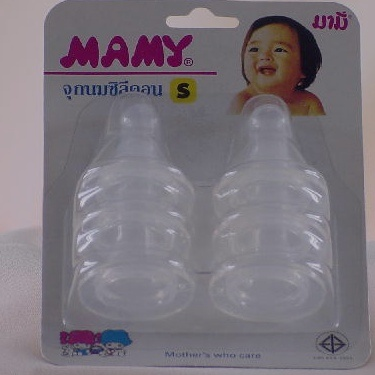

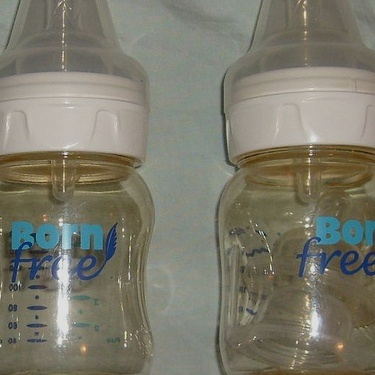

In [64]:
show_images('03825788')

Synset('barrow.n.01')
13764897
Synset('burial_mound.n.01')
2922292
Synset('barrow.n.03')
2797295


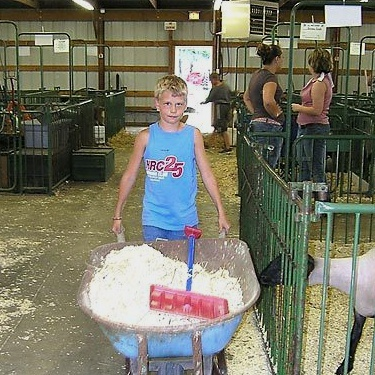

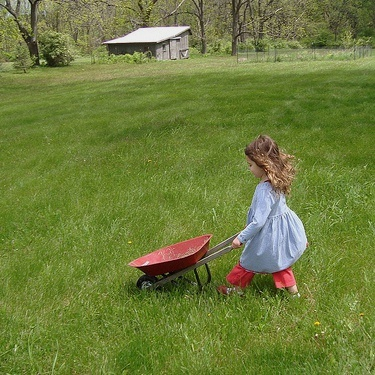

In [91]:
show_synset('barrow')

In [113]:
show_synset('')

Synset('blue_whale.n.01')
2064816


In [105]:
df.category.unique()

array(['invertebrate', 'artifact', 'food', 'animal', 'structure', 'plant',
       'geological_formation', 'person'], dtype=object)

In [106]:
df.category.value_counts()

artifact                984
animal                  673
structure               123
invertebrate            105
food                     99
plant                    41
geological_formation     20
person                    6
Name: category, dtype: int64

In [107]:
df.supercategory.unique()

array(['inanimate', 'animate', 'place'], dtype=object)

In [118]:
df.supercategory.value_counts()

artifact          984
vertebrate        679
place             143
natural_object    140
invertebrate      105
Name: supercategory, dtype: int64

In [119]:
df.set_index('image').to_pickle(dataset_v2 / 'imagenet_categories.pkl')

## Old Categorize

In [8]:
def categorize(synset):
    category = None
    ss = wn.synset(synset)
    hypernyms = list(set([w for s in ss.closure(lambda s:s.hypernyms()) for w in s.lemma_names()]))
    
    if 'artifact' in hypernyms:
        category = 'inanimate'
        
    if 'food' in hypernyms:
        if category:
            print(f'ERROR: Collision, {ss}, {category}, food')
        else:
            category = 'inanimate'
        
    if 'person' in hypernyms:
        if category:
            print(f'ERROR: Collision, {ss}, {category}, person')
        category = 'animate'
        
    if 'animal' in hypernyms:
        if category:
            print(f'ERROR: Collision, {ss}, {category}, animal')
        category = 'animate'
    
    if 'plant' in hypernyms:
        if category:
            print(f'ERROR: Collision, {ss}, {category}, plant')
        category = 'inanimate'
        
    if 'fungus' in hypernyms:
        if category:
            print(f'ERROR: Collision, {ss}, {category}, fungus')
        category = 'inanimate'
        
    if 'structure' in hypernyms:
        if category:
            print(f'WARNING: Collision, {ss}, {category}, structure')
        category = 'place'
    
    
    # if 'organism' in hypernyms:
    #     if category:
    #         print(f'ERROR: Collision, {ss}, {category}, organism')
    #     else:
    #         category = 'organism'
            
            
    if 'geological_formation' in hypernyms:
        if category:
            print(f'ERROR: Collision, {ss}, {category}, place')
        else:
            category = 'place'
    
    # Special cases
    if not category:
        # Plants that didn't fall under food
        if 'plant_part' in hypernyms:
            category = 'organism'
        else:
        # traffic_light, street_sign, bubble, toilet_tissue
            category = 'artifact'
            
    return category

In [9]:
df['category'] = df.synset.map(categorize)

ERROR: Collision, Synset('lumbermill.n.01'), place, plant
ERROR: Collision, Synset('lumbermill.n.01'), place, plant


/s/babbage/b/nobackup/nblancha/merry/conda/envs/fmri-gen/lib/python3.8/site-packages/nltk/corpus/reader/wordnet.py:599: UserWarning: Discarded redundant search for Synset('matter.n.03') at depth 7
  for synset in acyclic_breadth_first(self, rel, depth):
/s/babbage/b/nobackup/nblancha/merry/conda/envs/fmri-gen/lib/python3.8/site-packages/nltk/corpus/reader/wordnet.py:599: UserWarning: Discarded redundant search for Synset('animal.n.01') at depth 10
  for synset in acyclic_breadth_first(self, rel, depth):
/s/babbage/b/nobackup/nblancha/merry/conda/envs/fmri-gen/lib/python3.8/site-packages/nltk/corpus/reader/wordnet.py:599: UserWarning: Discarded redundant search for Synset('animal.n.01') at depth 8
  for synset in acyclic_breadth_first(self, rel, depth):
/s/babbage/b/nobackup/nblancha/merry/conda/envs/fmri-gen/lib/python3.8/site-packages/nltk/corpus/reader/wordnet.py:599: UserWarning: Discarded redundant search for Synset('instrumentality.n.03') at depth 7
  for synset in acyclic_breadth

## Apply to Participant

In [159]:
df = pd.read_pickle(dataset_v2 / 'CSI1_dataframe.pkl')
df_imagenet = df[df.dataset == 'ImageNet'].copy()
df_imagenet['synset'] = df_imagenet.image.map(get_synset)
df_imagenet

,image,dataset,synset
0,n01930112_19568.JPEG,ImageNet,nematode.n.01
1,n03733281_29214.JPEG,ImageNet,maze.n.01
2,n07695742_5848.JPEG,ImageNet,pretzel.n.01
5,n01917289_1429.JPEG,ImageNet,brain_coral.n.01
6,n02108551_26574.JPEG,ImageNet,tibetan_mastiff.n.01
...,...,...,...
5243,n09421951_5433.JPEG,ImageNet,sandbar.n.01
5245,n02018207_3567.JPEG,ImageNet,american_coot.n.01
5247,n01692333_12353.JPEG,ImageNet,gila_monster.n.01
5248,n03240683_13368.JPEG,ImageNet,drilling_platform.n.01


In [160]:
df_imagenet['category'] = df_imagenet.synset.map(categorize)
df_imagenet

/s/babbage/b/nobackup/nblancha/merry/conda/envs/fmri-gen/lib/python3.8/site-packages/nltk/corpus/reader/wordnet.py:599: UserWarning: Discarded redundant search for Synset('matter.n.03') at depth 7
  for synset in acyclic_breadth_first(self, rel, depth):
/s/babbage/b/nobackup/nblancha/merry/conda/envs/fmri-gen/lib/python3.8/site-packages/nltk/corpus/reader/wordnet.py:599: UserWarning: Discarded redundant search for Synset('animal.n.01') at depth 10
  for synset in acyclic_breadth_first(self, rel, depth):
/s/babbage/b/nobackup/nblancha/merry/conda/envs/fmri-gen/lib/python3.8/site-packages/nltk/corpus/reader/wordnet.py:599: UserWarning: Discarded redundant search for Synset('animal.n.01') at depth 8
  for synset in acyclic_breadth_first(self, rel, depth):
/s/babbage/b/nobackup/nblancha/merry/conda/envs/fmri-gen/lib/python3.8/site-packages/nltk/corpus/reader/wordnet.py:599: UserWarning: Discarded redundant search for Synset('instrumentality.n.03') at depth 7
  for synset in acyclic_breadth

,image,dataset,synset,category
0,n01930112_19568.JPEG,ImageNet,nematode.n.01,organism
1,n03733281_29214.JPEG,ImageNet,maze.n.01,artifact
2,n07695742_5848.JPEG,ImageNet,pretzel.n.01,food
5,n01917289_1429.JPEG,ImageNet,brain_coral.n.01,organism
6,n02108551_26574.JPEG,ImageNet,tibetan_mastiff.n.01,organism
...,...,...,...,...
5243,n09421951_5433.JPEG,ImageNet,sandbar.n.01,place
5245,n02018207_3567.JPEG,ImageNet,american_coot.n.01,organism
5247,n01692333_12353.JPEG,ImageNet,gila_monster.n.01,organism
5248,n03240683_13368.JPEG,ImageNet,drilling_platform.n.01,artifact


### Sanity Checks

In [161]:
df_imagenet[df_imagenet.category.isna()]

,image,dataset,synset,category


In [162]:
df_imagenet.category.value_counts()

artifact    1109
organism     823
food          99
place         20
Name: category, dtype: int64

In [163]:
df_imagenet.synset.unique().shape

(958,)

### Merge

In [180]:
df.index.name = 'index'
df_imagenet.index.name = 'index'

In [188]:
df_categories = df.merge(df_imagenet, how='left', left_on=['index', 'image', 'dataset'], right_on=['index', 'image', 'dataset'])
df_categories

,image,dataset,synset,category
index,,,,
0,n01930112_19568.JPEG,ImageNet,nematode.n.01,organism
1,n03733281_29214.JPEG,ImageNet,maze.n.01,artifact
2,n07695742_5848.JPEG,ImageNet,pretzel.n.01,food
3,COCO_train2014_000000420713.jpg,COCO,NaN,NaN
4,COCO_train2014_000000488558.jpg,COCO,NaN,NaN
...,...,...,...,...
5249,n03459775_11670.JPEG,ImageNet,grille.n.02,artifact
5250,COCO_train2014_000000523236.jpg,COCO,NaN,NaN
5251,dinosaur4.jpg,Scene,NaN,NaN


In [193]:
df_categories.loc[df_categories.dataset == 'Scene', 'category'] = 'place'

In [194]:
df_categories

,image,dataset,synset,category
index,,,,
0,n01930112_19568.JPEG,ImageNet,nematode.n.01,organism
1,n03733281_29214.JPEG,ImageNet,maze.n.01,artifact
2,n07695742_5848.JPEG,ImageNet,pretzel.n.01,food
3,COCO_train2014_000000420713.jpg,COCO,NaN,NaN
4,COCO_train2014_000000488558.jpg,COCO,NaN,NaN
...,...,...,...,...
5249,n03459775_11670.JPEG,ImageNet,grille.n.02,artifact
5250,COCO_train2014_000000523236.jpg,COCO,NaN,NaN
5251,dinosaur4.jpg,Scene,NaN,place


In [195]:
df_categories.to_pickle(dataset_v2 / 'CSI1_categories.pkl')